# NBA Lineup Prediction

This project focuses on building a machine learning model to predict the optimal fifth player for a home team NBA lineup, based on historical game data from 2007 to 2015. By analyzing partial team compositions and allowed game features, the goal is to improve the home team's performance using data-driven player recommendations. The model is built using XGBoost, a powerful gradient boosting algorithm known for high performance in classification tasks. The solution adheres strictly to feature constraints provided via metadata and ensures valid and explainable predictions.

## Import Libraries

Before we begin, we import all necessary libraries for data handling, preprocessing, modeling, and visualization.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import random
from sklearn.metrics import classification_report

## Extract Allowed Features from Matchup-Metadata

The metadata file defines which features are permitted in our model. We filter our dataset to only include these features.

In [8]:
metadata_path = "./data/Matchup-metadata.xlsx"
metadata_df=pd.read_excel(metadata_path)

#view metadata
metadata_df

,Feature,Short description,Can be used in the model,Cannot be used in the model
0,game,Game identifier,x,NaN
1,season,Season,x,NaN
2,home_team,Home team,x,NaN
3,away_team,Away team,x,NaN
4,starting_min,Starting minute of the lineup,x,NaN
5,end_min,Ending minut of the lineup,NaN,x
6,home_0,Home team players,x,NaN
7,home_1,Home team players,x,NaN
8,home_2,Home team players,x,NaN
9,home_3,Home team players,x,NaN


Select only features that can be used in the model, including outcome as stated in the project guidelines. It will play a part later in determining the training and testing set.

In [118]:
allowed_features = metadata_df[metadata_df["Can be used in the model "] == "x"]["Feature"].tolist()
allowed_features.append("outcome")

allowed_features

['game',
 'season',
 'home_team',
 'away_team',
 'starting_min',
 'home_0',
 'home_1',
 'home_2',
 'home_3',
 'home_4',
 'away_0',
 'away_1',
 'away_2',
 'away_3',
 'away_4',
 'outcome']

## Load and Merge NBA Matchup Data 

We load and merge NBA data from 2007-2015 season to create a single, comprehensive dataset that captures only the allowed columns from each CSV.

In [120]:
data_folder = "data"
df_list = []
for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(data_folder, file)
        # Read only the allowed columns from each CSV
        df_subset = pd.read_csv(file_path, usecols=allowed_features)
        df_list.append(df_subset)

df = pd.concat(df_list, ignore_index=True)
df = df[df['outcome'] == 1] #select only instances where home team won
df

,game,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4,outcome
5,201410290SAC,2015,SAC,GSW,11,Carl Landry,Derrick Williams,Nik Stauskas,Ramon Sessions,Reggie Evans,Andre Iguodala,Festus Ezeli,Klay Thompson,Leandro Barbosa,Marreese Speights,1
7,201410290SAC,2015,SAC,GSW,13,Carl Landry,Derrick Williams,Nik Stauskas,Ramon Sessions,Reggie Evans,Andre Iguodala,Andrew Bogut,Justin Holiday,Leandro Barbosa,Marreese Speights,1
12,201410290SAC,2015,SAC,GSW,20,Ben McLemore,Carl Landry,Darren Collison,DeMarcus Cousins,Rudy Gay,Draymond Green,Harrison Barnes,Klay Thompson,Ognjen Kuzmic,Stephen Curry,1
16,201410290SAC,2015,SAC,GSW,26,Ben McLemore,Darren Collison,DeMarcus Cousins,Jason Thompson,Rudy Gay,Draymond Green,Festus Ezeli,Harrison Barnes,Klay Thompson,Stephen Curry,1
18,201410290SAC,2015,SAC,GSW,29,Carl Landry,Darren Collison,Jason Thompson,Nik Stauskas,Rudy Gay,Andre Iguodala,Draymond Green,Klay Thompson,Ognjen Kuzmic,Stephen Curry,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236875,200812190MEM,2009,MEM,CHA,16,Darko Milicic,Greg Buckner,Marc Gasol,Mike Conley,O.J. Mayo,Boris Diaw,D.J. Augustin,Juwan Howard,Matt Carroll,Nazr Mohammed,1
236881,200812190MEM,2009,MEM,CHA,29,Darko Milicic,Mike Conley,O.J. Mayo,Quinton Ross,Rudy Gay,Boris Diaw,Emeka Okafor,Gerald Wallace,Raja Bell,Raymond Felton,1
236883,200812190MEM,2009,MEM,CHA,34,Greg Buckner,Marc Gasol,Mike Conley,Quinton Ross,Rudy Gay,Boris Diaw,D.J. Augustin,Emeka Okafor,Raja Bell,Raymond Felton,1
236884,200812190MEM,2009,MEM,CHA,35,Greg Buckner,Hakim Warrick,Marc Gasol,Mike Conley,Rudy Gay,Boris Diaw,D.J. Augustin,Emeka Okafor,Raja Bell,Raymond Felton,1


## Handle Missing Values
We check for any missing values in the dataset. If any rows have missing data, we drop them to ensure the model doesn't train on incomplete or inconsistent information.

In [121]:
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 game            0
season          0
home_team       0
away_team       0
starting_min    0
home_0          0
home_1          0
home_2          0
home_3          0
home_4          0
away_0          0
away_1          0
away_2          0
away_3          0
away_4          0
outcome         0
dtype: int64


We drop any in case:

In [122]:
df = df.dropna()

In [123]:
#verify again
print("Missing values after cleaning:\n", df.isnull().sum())

Missing values after cleaning:
 game            0
season          0
home_team       0
away_team       0
starting_min    0
home_0          0
home_1          0
home_2          0
home_3          0
home_4          0
away_0          0
away_1          0
away_2          0
away_3          0
away_4          0
outcome         0
dtype: int64


## Label Encode Columns

Label encoding converts categorical text data such as team and player names, into numerical values so that XGBoost can process them. Since our model can't work with strings, each unique category is assigned a unique integer. This ensures all input features are in a numeric format without changing their meaning, allowing the model to interpret and learn from the data effectively.

In [124]:
Column_names = ["game","home_team","away_team","home_0","home_1","home_2","home_3","away_0","away_1","away_2","away_3","away_4"]

label_encoders = {}
for col in Column_names:
    if col in df.columns:
        le_col = LabelEncoder()
        df[col] = le_col.fit_transform(df[col].astype(str))
        label_encoders[col] = le_col
    else:
        print(f"Warning: Column {col} not found in df.")

Preview of encoded columns:

In [125]:
df

,game,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,home_4,away_0,away_1,away_2,away_3,away_4,outcome
5,8692,2015,25,10,11,126,211,595,546,Reggie Evans,41,294,472,390,289,1
7,8692,2015,25,10,13,126,211,595,546,Reggie Evans,41,22,437,390,289,1
12,8692,2015,25,10,20,81,94,125,73,Rudy Gay,281,331,472,521,507,1
16,8692,2015,25,10,26,81,182,136,232,Rudy Gay,281,294,272,359,507,1
18,8692,2015,25,10,29,126,182,329,494,Rudy Gay,41,249,472,521,507,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236875,2475,2009,14,3,16,210,309,510,456,O.J. Mayo,102,152,441,452,342,1
236881,2475,2009,14,3,29,210,609,602,540,Rudy Gay,102,275,252,564,416,1
236883,2475,2009,14,3,34,338,567,558,540,Rudy Gay,102,152,219,564,416,1
236884,2475,2009,14,3,35,338,316,510,456,Rudy Gay,102,152,219,564,416,1


## Remove Rare Target Classes for Better Model Learning

We remove rarely occurring players in the target column (home_4) because they do not provide enough data for the model to learn meaningful patterns. When a player appears only once or very few times in the dataset, the model cannot generalize or make accurate predictions for that class, which introduces noise and reduces overall model performance. Additionally, if a rare player appears in the test set but was never seen during training, it can cause errors or unreliable results. By removing these rare classes before splitting the data, we ensure a more balanced and effective training process.

In [126]:
# Before removing rare classes
print("Unique target classes BEFORE removal:", df["home_4"].nunique())
print("Number of classes with <2 samples BEFORE removal:", sum(df["home_4"].value_counts() < 2))

Unique target classes BEFORE removal: 595
Number of classes with <2 samples BEFORE removal: 47


In [127]:
if "home_4" not in df.columns:
    raise ValueError("Column 'home_4' not found. Please ensure it is included in the data.")

freq = df["home_4"].value_counts()
rare_classes = freq[freq < 2].index
df = df[~df["home_4"].isin(rare_classes)].copy()

X = df.drop(columns=["home_4"])
y_raw = df["home_4"]

# Single encoder for the target
target_le = LabelEncoder()
y_full = target_le.fit_transform(y_raw)  # Encoded target for the entire dataset

In [128]:
# After removing rare classes
print("Unique target classes AFTER removal:", df["home_4"].nunique())
print("Number of classes with <2 samples AFTER removal:", sum(df["home_4"].value_counts() < 2))

Unique target classes AFTER removal: 548
Number of classes with <2 samples AFTER removal: 0


## Train-Test Split

In this section, we split the dataset into training and testing sets according to the project’s guidelines. The training data consists of the encoded dataframe with full team lineups and allowed features, including the performance outcomes of teams. This allows the model to learn from a wide range of scenarios across different matchups. The test data, however, is constructed specifically from game segments where the home team performed better (outcome = 1). This ensures that during final evaluation, the model is tested on scenarios where it must predict the fifth home player in a lineup that led to a better home team performance. Each test sample includes the first four home players, all five away players, and other relevant game features.

We divide our dataset into two parts: 80% for training and 20% for testing. We use stratified sampling to make sure that the mix of players in the training and test sets stays the same. In other words, if a certain player shows up often in the full dataset, they will show up just as often in both the training and test sets. This helps the model learn and perform fairly across all player types, instead of being biased toward the most common ones.

In [129]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_full,
    test_size=0.20,
    random_state=SEED,
    stratify=y_full
)

print(f"Train set: {len(X_train)} samples, Test set: {len(X_test)} samples")

Train set: 70502 samples, Test set: 17626 samples


After splitting the data, we reset the indexes of both the features (X) and target (y) to ensure they are properly aligned from 0 to N-1. This step is important because the original indexing from the split may be uneven or non-sequential, which can lead to confusion or misalignment when working with rows. Resetting the indexes ensures that each row in X_train and X_test matches exactly with its corresponding label in y_train and y_test, preventing potential errors during model training and evaluation.

In [131]:
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

# Convert y to Pandas Series with the same indexing
y_train = pd.Series(y_train, name="home_4").reset_index(drop=True)
y_test  = pd.Series(y_test,  name="home_4").reset_index(drop=True)

#### Move rows where outcome == -1 from test to train

According to project guidelines, only test games where home team performed better (outcome=1) should be used for evaluation. So, we move outcome=-1 rows back to the training set to keep the test set clean and valid.

In [132]:
X_test

,game,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,outcome
0,29,2007,12,27,41,154,139,96,630,102,530,503,564,513,1
1,5702,2012,7,32,7,40,48,113,486,3,201,208,211,167,1
2,7293,2013,26,10,35,97,565,536,479,133,249,237,228,195,1
3,4778,2011,20,0,19,391,400,434,489,400,398,388,314,316,1
4,1888,2008,1,31,7,494,496,624,545,292,295,358,284,198,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17621,242,2007,16,15,22,46,109,552,472,172,158,270,199,321,1
17622,7963,2014,17,24,11,24,172,273,335,250,421,459,508,515,1
17623,7425,2013,13,20,31,272,509,545,523,311,326,699,617,609,1
17624,1117,2008,27,25,13,60,97,393,303,8,98,276,334,204,1


As shown above, some test samples still contain outcome = -1, which violates the project guideline that test data must only include games where the home team performed better (outcome = 1). To solve this, these rows must be removed from the test set and added back to the training set so that the model is only evaluated on the correct type of game scenarios.

In [133]:
if 'outcome' in X_test.columns:
    mask_outcome = (X_test['outcome'] == -1)
    indices_to_move = X_test.index[mask_outcome]

    X_move = X_test.loc[indices_to_move]
    y_move = y_test.loc[indices_to_move]

    # Drop them from test
    X_test.drop(indices_to_move, inplace=True)
    y_test.drop(indices_to_move, inplace=True)

    # Reset index again
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    # Concatenate these rows into train
    X_train = pd.concat([X_train, X_move], ignore_index=True)
    y_train = pd.concat([y_train, y_move], ignore_index=True)

Finally, we verify that all test rows now have outcome = 1.

In [134]:
X_test

,game,season,home_team,away_team,starting_min,home_0,home_1,home_2,home_3,away_0,away_1,away_2,away_3,away_4,outcome
0,29,2007,12,27,41,154,139,96,630,102,530,503,564,513,1
1,5702,2012,7,32,7,40,48,113,486,3,201,208,211,167,1
2,7293,2013,26,10,35,97,565,536,479,133,249,237,228,195,1
3,4778,2011,20,0,19,391,400,434,489,400,398,388,314,316,1
4,1888,2008,1,31,7,494,496,624,545,292,295,358,284,198,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17621,242,2007,16,15,22,46,109,552,472,172,158,270,199,321,1
17622,7963,2014,17,24,11,24,172,273,335,250,421,459,508,515,1
17623,7425,2013,13,20,31,272,509,545,523,311,326,699,617,609,1
17624,1117,2008,27,25,13,60,97,393,303,8,98,276,334,204,1


In [135]:
num_negative_outcomes = (X_test["outcome"] == -1).sum()
print(f"\nNumber of outcome = -1 in test set after removal:")
num_negative_outcomes


Number of outcome = -1 in test set after removal:


np.int64(0)

### Handling Missing Classes in Training Set

This ensures that the model has seen at least one example of every class it may need to predict during testing. If there are any player labels that exist in the test set but are completely missing from the training set, the model will not be able to predict them correctly, which could lead to errors or inaccurate results.

To solve this, we identify the missing labels and use synthetic oversampling to add at least one sample of each missing class into the training set. We do this by duplicating a random row from `X_train` and assigning the missing label to it in `y_train`. It gives the model a minimal exposure to those labels so it can include them in the prediction class space. Finally, we re-check to confirm that all test labels are now also present in the training set.

This step helps stabilize model training, ensures label consistency across datasets, and prevents the model from throwing errors or ignoring valid test classes it was never trained on.

In [136]:
all_train_classes = np.unique(y_train)
all_test_classes  = np.unique(y_test)

missing_labels = np.setdiff1d(all_test_classes, all_train_classes)
print("Labels present in test but missing in train:", missing_labels)

Labels present in test but missing in train: []


In [138]:
# Add synthetic entries for missing labels
for label in missing_labels:
    # Random row from X_train
    random_idx = np.random.choice(X_train.index)
    row_to_duplicate = X_train.loc[[random_idx]]

    # Append to X_train
    X_train = pd.concat([X_train, row_to_duplicate], ignore_index=True)

    # Append the missing label
    y_train = pd.concat([y_train, pd.Series([label])], ignore_index=True)

# Re-check
all_train_classes = np.unique(y_train)
missing_after_fix = np.setdiff1d(all_test_classes, all_train_classes)
print("Missing labels after fix:", missing_after_fix)

Missing labels after fix: []


### Removing Low-Frequency Classes to Further Improve Model

We want to remove player classes from the training and test sets that appear less than 3 times in the dataset. This is because these low-frequency classes don’t provide enough data for the model to learn meaningful patterns and can actually introduce noise or imbalance. Filtering them out helps the model train more effectively and improves overall stability.

Before filtering, we examine how many times each player (class) appears in the training set. This helps us identify low-frequency (sparse) classes that may not provide enough data for learning.

In [139]:
freq_train = Counter(y_train)
print("\nClass frequencies (train) BEFORE removal:", freq_train)


Class frequencies (train) BEFORE removal: Counter({480: 1608, 544: 1384, 447: 1067, 441: 1064, 536: 1017, 505: 1001, 527: 989, 465: 964, 490: 958, 545: 945, 510: 941, 459: 913, 517: 893, 464: 867, 355: 856, 391: 847, 445: 793, 534: 760, 509: 730, 498: 721, 456: 713, 326: 692, 499: 682, 426: 677, 443: 665, 487: 631, 547: 603, 438: 577, 350: 575, 130: 572, 387: 553, 277: 542, 419: 533, 384: 532, 501: 532, 477: 524, 526: 513, 530: 482, 289: 481, 413: 478, 495: 463, 323: 460, 348: 458, 424: 453, 395: 449, 411: 433, 379: 433, 524: 433, 470: 428, 539: 414, 260: 413, 507: 399, 402: 394, 207: 393, 364: 392, 473: 381, 315: 380, 454: 378, 238: 376, 394: 376, 519: 375, 345: 371, 491: 369, 485: 362, 492: 357, 276: 357, 462: 344, 321: 333, 476: 332, 393: 331, 327: 324, 421: 320, 127: 316, 515: 314, 368: 313, 359: 309, 504: 309, 381: 309, 295: 305, 448: 285, 385: 281, 353: 277, 193: 272, 236: 268, 396: 265, 220: 261, 262: 253, 344: 248, 189: 245, 538: 245, 346: 240, 469: 237, 435: 231, 430: 230, 82

We define a minimum number of samples required per class (`min_samples`). Any class that appears fewer times than this threshold is considered sparse and will be removed.

In [140]:
min_samples = 3
sparse_classes = [cls for cls, count in freq_train.items() if count < min_samples]
print("Sparse classes (< {} samples): {}".format(min_samples, sparse_classes))

Sparse classes (< 3 samples): [213, 120, 546, 3, 27, 18, 157, 107, 13, 8, 281, 149, 2, 72, 64, 162, 69, 275, 21, 301, 121, 101, 22, 141, 249, 280, 20, 147, 159, 192, 540, 48, 24, 129, 137, 182, 293, 14, 19, 106, 54, 285, 451, 138, 228, 53, 99, 331, 287, 142, 32]


We now remove all rows in the training set and test set that belong to the sparse classes. This cleanup reduces noise and helps the model focus on better-represented classes.

In [141]:
mask_train = ~y_train.isin(sparse_classes)
X_train_filtered = X_train.loc[mask_train].reset_index(drop=True)
y_train_filtered = y_train.loc[mask_train].reset_index(drop=True)

mask_test = ~y_test.isin(sparse_classes)
X_test_filtered = X_test.loc[mask_test].reset_index(drop=True)
y_test_filtered = y_test.loc[mask_test].reset_index(drop=True)

After removing sparse player classes from the training and test sets, we need to re-encode home_4 again. This is important because some class labels (player IDs) were removed in the filtering step, meaning the original encoded label mapping is no longer valid or continuous.

In [142]:
final_le = LabelEncoder()
y_train_enc = final_le.fit_transform(y_train_filtered)
y_test_enc  = final_le.transform(y_test_filtered)

## Train XGBoost Model

We initialize and train the XGBoost classifier using the prepared training data.

In [147]:
params = {
    'subsample': 1.0,
    'n_estimators': 300,
    'max_depth': 7,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'device': 'cuda',
    'predictor': 'gpu_predictor',
    'n_jobs': 1,
    'eval_metric': 'mlogloss'
}

model = xgb.XGBClassifier(**params)

#Evaluate on the training set itself to show iteration progress.
eval_set = [(X_train_filtered, y_train_enc)]
model.fit(
    X_train_filtered,
    y_train_enc,
    eval_set=eval_set,
    verbose=True
)

/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:3.42727
[1]	validation_0-mlogloss:2.56382
[2]	validation_0-mlogloss:2.22658
[3]	validation_0-mlogloss:1.99380
[4]	validation_0-mlogloss:1.81344
[5]	validation_0-mlogloss:1.66752
[6]	validation_0-mlogloss:1.54741
[7]	validation_0-mlogloss:1.44370
[8]	validation_0-mlogloss:1.35388
[9]	validation_0-mlogloss:1.27549
[10]	validation_0-mlogloss:1.20631
[11]	validation_0-mlogloss:1.14264
[12]	validation_0-mlogloss:1.08586
[13]	validation_0-mlogloss:1.03399
[14]	validation_0-mlogloss:0.98713
[15]	validation_0-mlogloss:0.94388
[16]	validation_0-mlogloss:0.90438
[17]	validation_0-mlogloss:0.86771
[18]	validation_0-mlogloss:0.83364
[19]	validation_0-mlogloss:0.80180
[20]	validation_0-mlogloss:0.77210
[21]	validation_0-mlogloss:0.74427
[22]	validation_0-mlogloss:0.71800
[23]	validation_0-mlogloss:0.69328
[24]	validation_0-mlogloss:0.67031
[25]	validation_0-mlogloss:0.64860
[26]	validation_0-mlogloss:0.62808
[27]	validation_0-mlogloss:0.60813
[28]	validation_0-mlogloss:0.5

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=1,
              num_parallel_tree=None, ...)

We monitor the training progress using mlogloss, a loss metric used for multi-class problems. Training shows us how the model improves over time.

## Model Testing Predictions

The trained XGBoost model makes predictions on the filtered test dataset to determine the fifth player in the home team lineup.

In [148]:

#Predict on test set
preds_enc = model.predict(X_test_filtered)

#Decode predictions fully back to original player labels
#First map to filtered class labels, then back to original labels using both encoders
mapped_preds = final_le.classes_[preds_enc]
preds_decoded = target_le.inverse_transform(mapped_preds)

#Decode actual y_test values similarly
mapped_actuals = final_le.classes_[y_test_enc]
actual_decoded = target_le.inverse_transform(mapped_actuals)
#Decode home_team back to original label using label encoder
decoded_home_teams = label_encoders['home_team'].inverse_transform(X_test_filtered['home_team'])
#Decode game back to original label using label encoder
decoded_games = label_encoders['game'].inverse_transform(X_test_filtered['game'])

prediction_output = pd.DataFrame({
    'game': decoded_games,
    'home_team': decoded_home_teams,
    'home_04': preds_decoded
})


These predictions are then exported to a CSV file titled prediction-outputs.csv, which includes the game ID, home team, and the predicted fifth player.

In [149]:
#Save prediction output to CSV
prediction_output.to_csv("prediction-outputs.csv", index=False)
print("Prediction file 'prediction-outputs.csv' created successfully.")

Prediction file 'prediction-outputs.csv' created successfully.


## Model Evaluation

After training our XGBoost model, it is important to understand both how well the model learned during training and which features had the greatest impact on predictions.

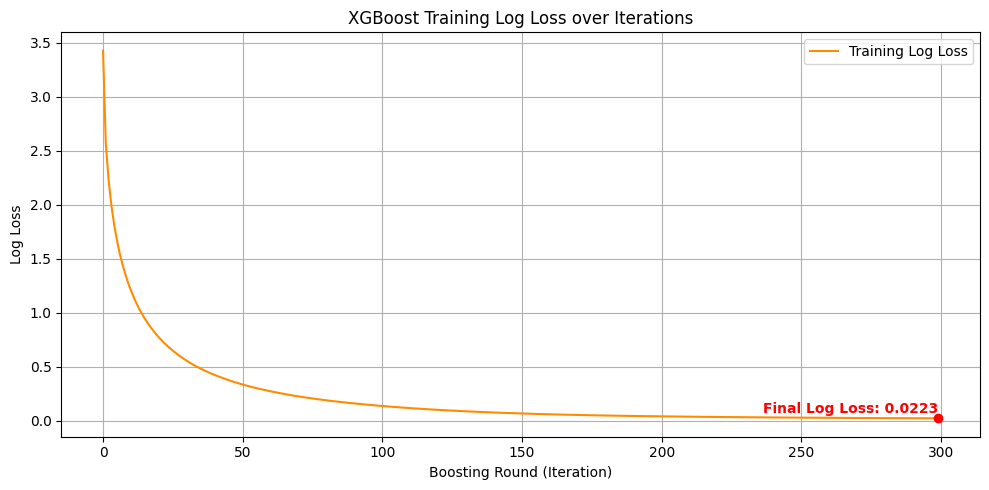

In [150]:
results = model.evals_result()

plt.figure(figsize=(10, 5))
loss_values = results['validation_0']['mlogloss']
plt.plot(loss_values, label='Training Log Loss', color='darkorange')

#Annotate the final value
final_val = loss_values[-1]
plt.scatter(len(loss_values)-1, final_val, color='red', zorder=5)
plt.text(len(loss_values)-1, final_val + 0.05, f"Final Log Loss: {final_val:.4f}", 
         ha='right', fontsize=10, color='red', fontweight='bold')

plt.xlabel("Boosting Round (Iteration)")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Log Loss over Iterations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

This plot shows how the XGBoost model’s training loss (log loss) changes with each boosting iteration. Log loss is a measure of how well the model is performing — lower values mean better predictions. As we can see, the log loss decreases steadily as the model learns, eventually reaching a very low value.

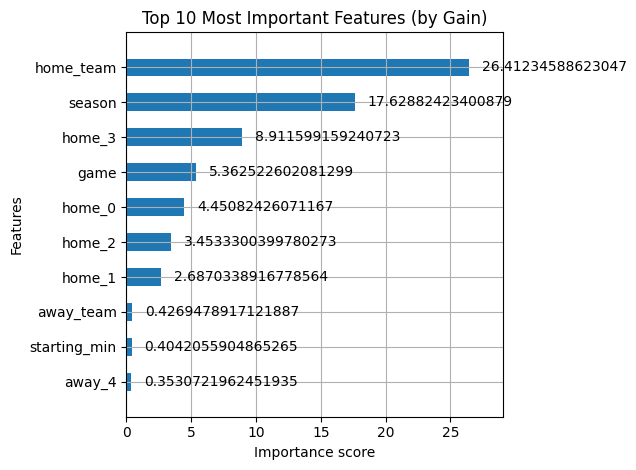

In [151]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10, height=0.5)
plt.title("Top 10 Most Important Features (by Gain)")
plt.tight_layout()
plt.show()

This feature importance plot shows which input features the XGBoost model relied on most when learning to predict the optimal fifth player in an NBA lineup. The values are based on "gain," which represents how much each feature contributed to improving the model's accuracy during training. From the graph, we see that features like home_3 and home_team have the highest importance, meaning the identity of the fourth home player already in the lineup and the overall team context significantly influence the model’s decisions. Other features like season, home_1, and game also play a key role, highlighting the importance of lineup composition and historical matchup context. In contrast, features such as starting_min, away_0, and away_team have lower importance, indicating they had less impact on the model’s learning process.

## Classification Metrics

In [152]:
print(classification_report(actual_decoded, preds_decoded))

                          precision    recall  f1-score   support

           Austin Rivers       0.00      0.00      0.00         1
           Brian Roberts       0.00      0.00      0.00         1
          Cuttino Mobley       0.50      0.50      0.50         4
              Dan Dickau       1.00      1.00      1.00         1
        Danilo Gallinari       1.00      1.00      1.00         1
           Darius Miller       1.00      1.00      1.00         1
          DeAndre Jordan       0.90      1.00      0.95         9
           DeMar DeRozan       1.00      1.00      1.00         1
       DeShawn Stevenson       0.85      0.85      0.85        20
               Dee Brown       1.00      1.00      1.00         1
            Devin Harris       1.00      1.00      1.00         1
         Dominic McGuire       0.00      0.00      0.00         1
           Dorell Wright       0.00      0.00      0.00         1
             Earl Watson       0.00      0.00      0.00         2
         

/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

After training the XGBoost model, we evaluated its performance using a classification report, which includes key metrics such as accuracy, precision, recall, and F1 score.

### Final Validation

In [160]:
test_df = pd.read_csv("./NBA_test.csv")
test_df

#ensure home_4 always has missing player to match training predictions
for idx, row in test_df.iterrows():
    question_mark_column = row[row == '?'].index[0]
    
    if question_mark_column != 'home_4':
        test_df.at[idx, 'home_4'], test_df.at[idx, question_mark_column] = test_df.at[idx, question_mark_column], test_df.at[idx, 'home_4']


X_test = test_df.drop(columns=["home_4"])
X_test['game'] = 1
X_test['outcome'] = 1
X_test = X_test[['game', 'season', 'home_team', 'away_team', 'starting_min', 'home_0', 'home_1', 'home_2', 'home_3', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4', 'outcome']]

y_test = test_df['home_4']

Column_names = ["game","home_team","away_team","home_0","home_1","home_2","home_3","away_0","away_1","away_2","away_3","away_4"]


for col in Column_names:
    if col in X_test.columns:
        # Get the set of seen classes from the encoder
        seen_classes = set(label_encoders[col].classes_)
        
        # Filter the X_test column to ensure no unseen categories
        X_test[col] = X_test[col].astype(str).apply(lambda x: x if x in seen_classes else seen_classes.pop())

        # Transform using the existing label encoder
        X_test[col] = label_encoders[col].transform(X_test[col])
    else:
        print(f"Warning: Column {col} not found in X_test.")

y_predict = model.predict(X_test)
y_predict

y_predict

y_actual = pd.read_csv("./NBA_test_labels.csv")['removed_value']
y_actual = target_le.fit_transform(y_actual)
y_actual

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

accuracy = accuracy_score(y_actual, y_predict)
precision = precision_score(y_actual, y_predict, average='weighted', zero_division=0)
recall = recall_score(y_actual, y_predict, average='weighted', zero_division=0)
f1 = f1_score(y_actual, y_predict, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(y_actual, y_predict)
class_report = classification_report(y_actual, y_predict)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.0030
Precision: 0.0023
Recall: 0.0030
F1-score: 0.0025


/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/justinfisher/Documents/school/ML/NBA-Lineup-Prediction/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis